# Basic Project: Transfer Learning

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from torch.utils.data import random_split
import os
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
import time 


Tic() Toc() Functions to track training time

In [2]:
def tic():
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    if 'startTime_for_tictoc' in globals():
        return time.time() - startTime_for_tictoc
        #print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")
        

In [3]:
data_root = "datasets"


Download ResNet18

In [4]:
# for ResNet18:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


Dataset

In [5]:
trainval_data = datasets.OxfordIIITPet(
        root=data_root,
        split='trainval',
        target_types='binary-category',
        transform=transform,
        download=False
    )
test_data = datasets.OxfordIIITPet(
        root=data_root,
        split='test',
        target_types='binary-category',
        transform=transform,
        download=False
    )


Train / Test Dataset Split

In [6]:
val_ratio = 0.2  # 20% for validation
train_size = int((1 - val_ratio) * len(trainval_data))
val_size = len(trainval_data) - train_size

train_data, val_data = random_split(trainval_data, [train_size, val_size])


In [7]:
len(val_data), len(train_data), len(test_data)


(736, 2944, 3669)

Data Loaders

In [8]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [9]:
dataloaders = {}
dataset_sizes = {}

dataloaders['train'] = train_loader
dataloaders['val'] = val_loader
dataloaders['test'] = test_loader

dataset_sizes['train'] = len(train_data)
dataset_sizes['val'] = len(val_data)


Initialize the Network

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cpu':
    print("If GPU is available: \npip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118")
    print("Restart the kernel and run the code again.")
    print("Check with `print(torch.cuda.is_available())`")
    print("Documentation: https://pytorch.org/get-started/locally/")
    
# ResNet18
network = models.resnet18(weights='DEFAULT')
nf = network.fc.in_features
network.fc = nn.Linear(nf, 2)
network = network.to(device)


Using device: cuda


Function to Train the Network

In [ ]:
def train_network(network, dataloaders, dataset_sizes, criterion, optimizer, num_epochs=25):

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Set Starting Time
    tic()

    with TemporaryDirectory() as tempdir:
        best_network_params_path = os.path.join(tempdir, 'best_network_params.pt')

        torch.save(network.state_dict(), best_network_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    network.train()
                else:
                    network.eval()

                running_loss = 0.0
                running_corrects = 0

                for X, Y in dataloaders[phase]:
                    X = X.to(device)
                    Y = Y.to(device)

                    optimizer.zero_grad()

                    # forward
                    with torch.set_grad_enabled(phase == 'train'):
                        S = network(X)
                        _, P = torch.max(S, 1)
                        loss = criterion(S, Y)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * X.size(0)
                    running_corrects += torch.sum(P == Y.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accuracies.append(epoch_acc.item())
                else:
                    val_losses.append(epoch_loss)
                    val_accuracies.append(epoch_acc.item())

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(network.state_dict(), best_network_params_path)

            print()

        print(f'Best val Acc: {best_acc:4f}')

        network.load_state_dict(torch.load(best_network_params_path, weights_only=True))
        
    # Print Time for Training only
    el_time_training = toc()
    print(f"\nTime for training: {el_time_training:.1f} sec.")
    
    return network, train_losses, val_losses, train_accuracies, val_accuracies


In [12]:
def compute_accuracy(network, loader, print_result=True):
    network.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X, Y in loader:
            X, Y = X.to(device), Y.to(device)
            S = network(X)
            _, P = torch.max(S, 1)
            correct += (P == Y).sum().item()
            total += Y.size(0)

    acc = 100 * correct / total
    if print_result:
        print(f"Test Accuracy: {acc:.2f}%")
        
    return acc


Define Entropy Criterion and the Optimizer

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=1e-4)


Train the Network

In [ ]:
# Running for 25 epochs
network, train_losses, val_losses, train_accuracies, val_accuracies = train_network(
    network, dataloaders, dataset_sizes, criterion, optimizer, num_epochs=25
)


Epoch 1/25
----------
train Loss: 0.0931 Acc: 0.9647
val Loss: 0.0346 Acc: 0.9864

Epoch 2/25
----------
train Loss: 0.0126 Acc: 0.9969
val Loss: 0.0359 Acc: 0.9823

Epoch 3/25
----------
train Loss: 0.0062 Acc: 0.9980
val Loss: 0.0256 Acc: 0.9864

Epoch 4/25
----------
train Loss: 0.0032 Acc: 0.9993
val Loss: 0.0240 Acc: 0.9878

Epoch 5/25
----------
train Loss: 0.0019 Acc: 0.9997
val Loss: 0.0272 Acc: 0.9851

Epoch 6/25
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.0255 Acc: 0.9864

Epoch 7/25
----------
train Loss: 0.0019 Acc: 1.0000
val Loss: 0.0278 Acc: 0.9837

Epoch 8/25
----------
train Loss: 0.0008 Acc: 1.0000
val Loss: 0.0198 Acc: 0.9878

Epoch 9/25
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.0235 Acc: 0.9891

Epoch 10/25
----------
train Loss: 0.0070 Acc: 0.9973
val Loss: 0.0921 Acc: 0.9742

Epoch 11/25
----------
train Loss: 0.0276 Acc: 0.9885
val Loss: 0.0819 Acc: 0.9715

Epoch 12/25
----------
train Loss: 0.0121 Acc: 0.9963
val Loss: 0.0585 Acc: 0.9837

E

Plot the Results

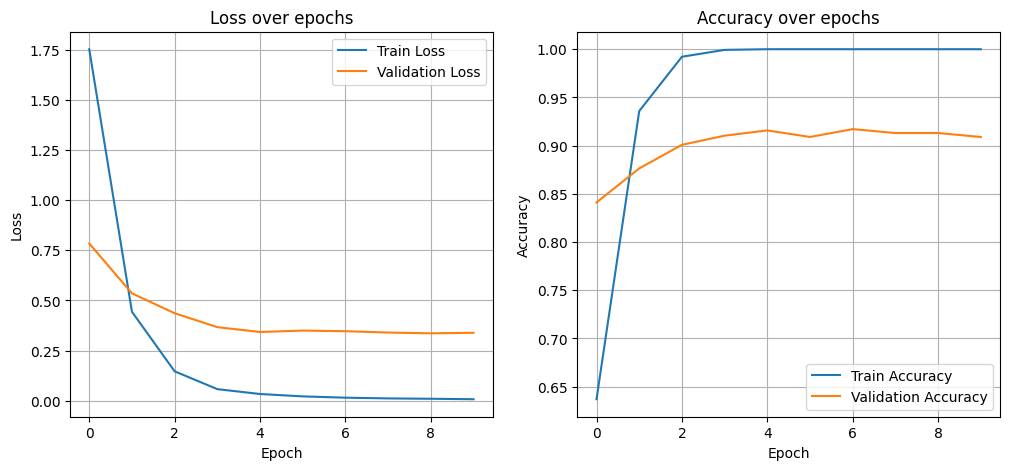

In [20]:
def VisLossAccuracy(train_losses, val_losses, train_accuracies, val_accuracies):

    plt.figure(facecolor='white', figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.grid()
    #plt.show()

    #plt.figure(facecolor='white')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    #plt.ylim([0.9, 1.02])
    plt.title('Accuracy over epochs')
    plt.grid()
    plt.show()
    

# Visualize the loss and accuracy of the Network
VisLossAccuracy(train_losses, val_losses, train_accuracies, val_accuracies)

In [17]:
compute_accuracy(network, test_loader)

Test Accuracy: 98.86%


98.85527391659853

## Multi-Class Problem
- Identifying all 37 breeds of Cats & Dogs

In [16]:
def Load_TrainTestData(data_root, target_types, transform):
    trainval_data = datasets.OxfordIIITPet(
        root=data_root,
        split='trainval',
        target_types=target_types,
        transform=transform,
        download=False
    )
    test_data = datasets.OxfordIIITPet(
        root=data_root,
        split='test',
        target_types=target_types,
        transform=transform,
        download=False
    )

    val_ratio = 0.2  # 20% for validation
    train_size = int((1 - val_ratio) * len(trainval_data))
    val_size = len(trainval_data) - train_size

    train_data, val_data = random_split(trainval_data, [train_size, val_size])
    
    return train_data, val_data, test_data


def DataLoaderFnc(train_data, val_data, test_data, batch_size=32):

    # Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    dataloaders = {}
    dataset_sizes = {}

    dataloaders['train'] = train_loader
    dataloaders['val'] = val_loader
    dataloaders['test'] = test_loader

    dataset_sizes['train'] = len(train_data)
    dataset_sizes['val'] = len(val_data)

    return dataloaders, dataset_sizes


def Initialize_ResNet18(no_target_classes=2):
    
    network = models.resnet18(weights='DEFAULT')
    nf = network.fc.in_features
    network.fc = nn.Linear(nf, no_target_classes)
    network = network.to(device)
    
    return network



# Load Train, Validation and Test Data
train_data, val_data, test_data = Load_TrainTestData(data_root, 'category', transform)

# Create DataLoaders
dataloaders, dataset_sizes = DataLoaderFnc(train_data, val_data, test_data, batch_size=32)

# Initialize ResNet18
init_network = Initialize_ResNet18(no_target_classes=37)
""" Tobi 05.05.2025:

Where and how can I freeze / unfreeze the layers of the ResNet18?

GPT:
# Freeze all layers
for param in network.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected layer
for param in network.fc.parameters():
    param.requires_grad = True
    
"""

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(init_network.parameters(), lr=1e-4)

# Train the network
network, train_losses, val_losses, train_accuracies, val_accuracies = train_network(
    init_network, dataloaders, dataset_sizes, criterion, optimizer, num_epochs=10
)

# Visualize the loss and accuracy of the Network
VisLossAccuracy(train_losses, val_losses, train_accuracies, val_accuracies)

# Print the Accuracy
final_acc = compute_accuracy(network, test_loader, print_result=True)


Epoch 1/10
----------
train Loss: 1.7539 Acc: 0.6369
val Loss: 0.7845 Acc: 0.8410

Epoch 2/10
----------
train Loss: 0.4435 Acc: 0.9358
val Loss: 0.5354 Acc: 0.8764

Epoch 3/10
----------
train Loss: 0.1463 Acc: 0.9922
val Loss: 0.4363 Acc: 0.9008

Epoch 4/10
----------
train Loss: 0.0574 Acc: 0.9993
val Loss: 0.3667 Acc: 0.9103

Epoch 5/10
----------
train Loss: 0.0331 Acc: 1.0000
val Loss: 0.3426 Acc: 0.9158

Epoch 6/10
----------
train Loss: 0.0212 Acc: 1.0000
val Loss: 0.3497 Acc: 0.9090

Epoch 7/10
----------
train Loss: 0.0148 Acc: 1.0000
val Loss: 0.3465 Acc: 0.9171

Epoch 8/10
----------
train Loss: 0.0111 Acc: 1.0000
val Loss: 0.3398 Acc: 0.9130

Epoch 9/10
----------
train Loss: 0.0094 Acc: 1.0000
val Loss: 0.3360 Acc: 0.9130

Epoch 10/10
----------
train Loss: 0.0071 Acc: 1.0000
val Loss: 0.3387 Acc: 0.9090

Best val Acc: 0.917120
Time for training: 517.6 sec.


NameError: name 'VisLossAccuracy' is not defined

Build one big Training Function

In [17]:
def TrainResNet18(data_root, target_types, transform, TrainParams):
    
    # Extract Training Parameters
    batch_size = TrainParams.get('batch_size', 32)
    num_epochs = TrainParams.get('num_epochs', 25)
    no_target_classes = TrainParams.get('no_target_classes', 2)
    lr = TrainParams.get('lr', 1e-4)
    L = TrainParams.get('L', 0)  # Number of layers to unfreeze / Train
    
    # Load Train, Validation and Test Data
    train_data, val_data, test_data = Load_TrainTestData(data_root, target_types, transform)

    # Create DataLoaders
    dataloaders, dataset_sizes = DataLoaderFnc(train_data, val_data, test_data, batch_size)

    # Initialize ResNet18
    init_network = Initialize_ResNet18(no_target_classes)
    
    # Freeze/Unfreeze Layers
    for l, param in enumerate(init_network.parameters()):
        if l <= L:
            param.requires_grad = True
        else:
            param.requires_grad = False

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(init_network.parameters(), lr)

    # Train the network
    network, train_losses, val_losses, train_accuracies, val_accuracies = train_network(
        init_network, dataloaders, dataset_sizes, criterion, optimizer, num_epochs
    )

    # Visualize the loss and accuracy of the Network
    VisLossAccuracy(train_losses, val_losses, train_accuracies, val_accuracies)

    # Print the Accuracy
    final_acc = compute_accuracy(network, test_loader, print_result=True)
    

### Strategy 1: Fine-tune $l$ layers simultaneously


Training with unfreezing layer 0...
Epoch 1/5
----------
train Loss: 3.8393 Acc: 0.0336
val Loss: 3.8377 Acc: 0.0299

Epoch 2/5
----------
train Loss: 3.8280 Acc: 0.0326
val Loss: 3.8286 Acc: 0.0340

Epoch 3/5
----------
train Loss: 3.8212 Acc: 0.0333
val Loss: 3.8206 Acc: 0.0380

Epoch 4/5
----------
train Loss: 3.8163 Acc: 0.0360
val Loss: 3.8113 Acc: 0.0380

Epoch 5/5
----------
train Loss: 3.8114 Acc: 0.0380
val Loss: 3.8103 Acc: 0.0340

Best val Acc: 0.038043
Time for training: 224.7 sec.


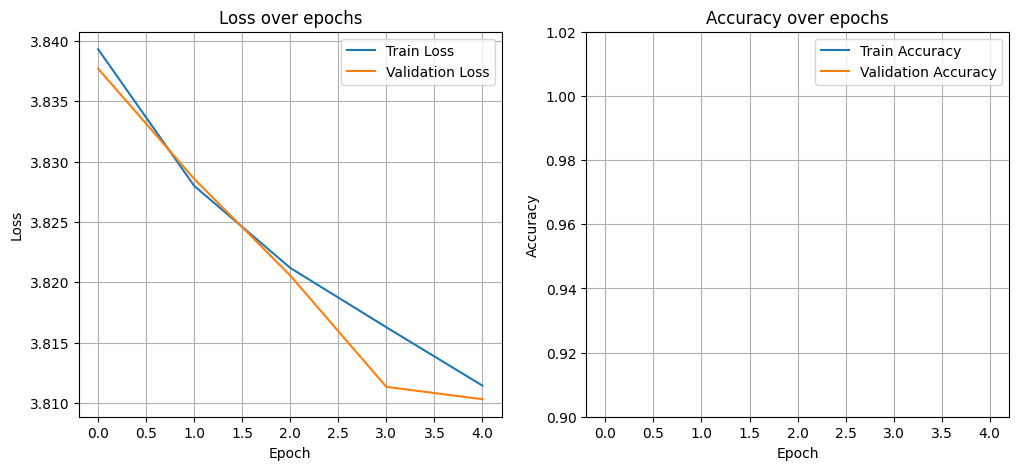

Test Accuracy: 0.05%
Finished training with unfreezing layer 0.

Training with unfreezing layer 1...
Epoch 1/5
----------
train Loss: 3.8147 Acc: 0.0112
val Loss: 3.7943 Acc: 0.0190

Epoch 2/5
----------
train Loss: 3.8089 Acc: 0.0129
val Loss: 3.7912 Acc: 0.0204

Epoch 3/5
----------
train Loss: 3.7976 Acc: 0.0156
val Loss: 3.7934 Acc: 0.0204

Epoch 4/5
----------
train Loss: 3.7940 Acc: 0.0153
val Loss: 3.7827 Acc: 0.0245

Epoch 5/5
----------
train Loss: 3.7891 Acc: 0.0136
val Loss: 3.7801 Acc: 0.0258

Best val Acc: 0.025815
Time for training: 206.5 sec.


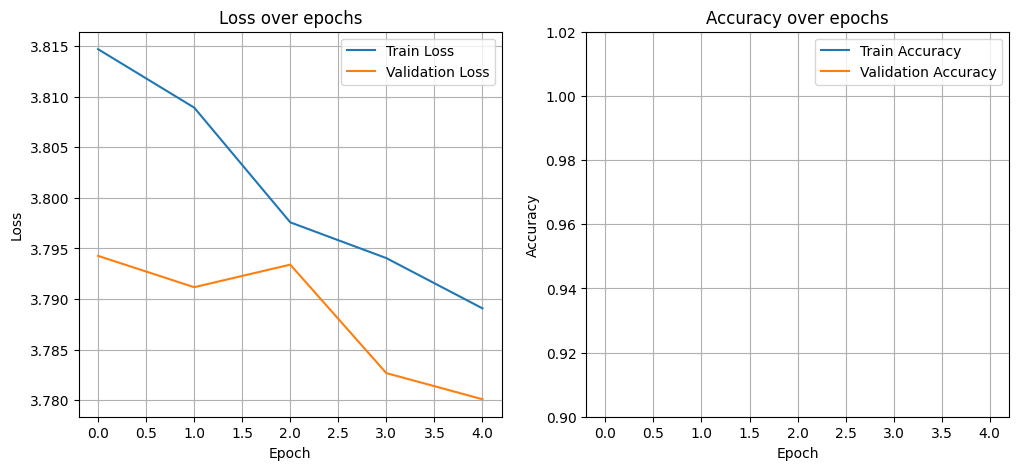

Test Accuracy: 2.26%
Finished training with unfreezing layer 1.

Training with unfreezing layer 2...
Epoch 1/5
----------
train Loss: 3.7831 Acc: 0.0279
val Loss: 3.7895 Acc: 0.0272

Epoch 2/5
----------
train Loss: 3.7680 Acc: 0.0302
val Loss: 3.7832 Acc: 0.0285

Epoch 3/5
----------
train Loss: 3.7625 Acc: 0.0285
val Loss: 3.7806 Acc: 0.0326

Epoch 4/5
----------
train Loss: 3.7565 Acc: 0.0306
val Loss: 3.7721 Acc: 0.0312

Epoch 5/5
----------
train Loss: 3.7519 Acc: 0.0282
val Loss: 3.7665 Acc: 0.0285

Best val Acc: 0.032609
Time for training: 261.5 sec.


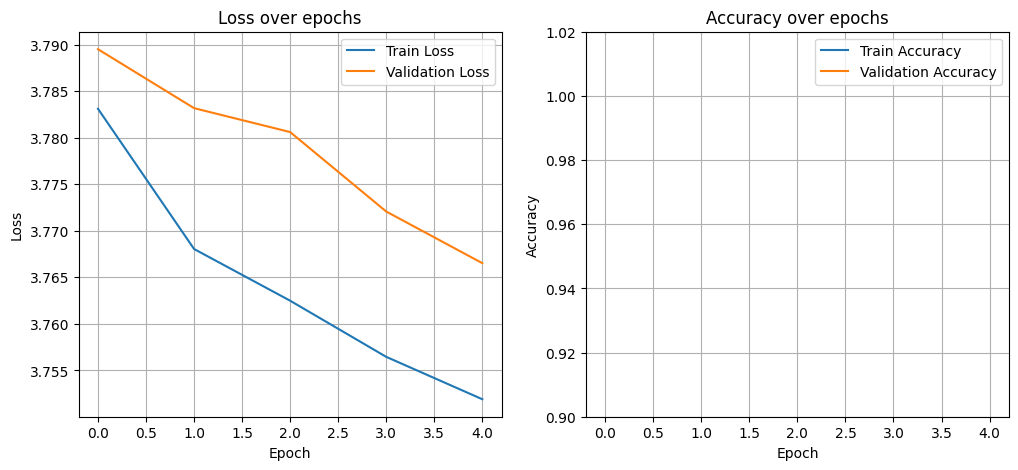

Test Accuracy: 9.13%
Finished training with unfreezing layer 2.

Training with unfreezing layer 3...
Epoch 1/5
----------
train Loss: 3.8557 Acc: 0.0299
val Loss: 3.8341 Acc: 0.0421

Epoch 2/5
----------
train Loss: 3.8276 Acc: 0.0306
val Loss: 3.8080 Acc: 0.0394

Epoch 3/5
----------
train Loss: 3.8057 Acc: 0.0360
val Loss: 3.7959 Acc: 0.0353

Epoch 4/5
----------
train Loss: 3.7869 Acc: 0.0374
val Loss: 3.7767 Acc: 0.0367

Epoch 5/5
----------
train Loss: 3.7729 Acc: 0.0363
val Loss: 3.7899 Acc: 0.0340

Best val Acc: 0.042120
Time for training: 222.2 sec.


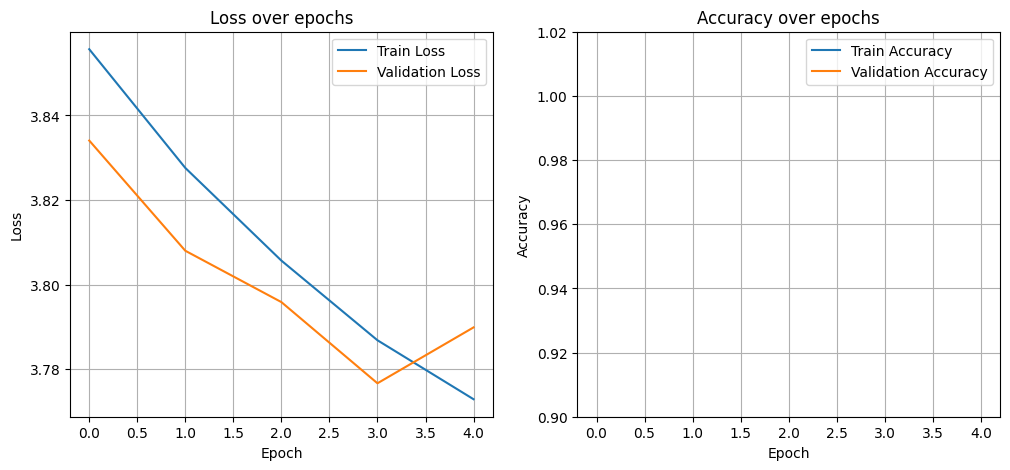

Test Accuracy: 0.00%
Finished training with unfreezing layer 3.


In [ ]:
# Layers to unfreeze
layers = [0, 3, 5, 10]

# Training Parameters
TrainParams = {
    'batch_size': 32,
    'num_epochs': 10,
    'no_target_classes': 37,
    'lr': 1e-4,
    'L': 0  # Unfreeze the last layer
}


# Loop through the layers and train the network
for l in layers:
    print(f"\nTraining with unfreezing layer {l}...")
    TrainParams['L'] = l  # Set the number of layers to unfreeze
    TrainResNet18(data_root, 'category', transform, TrainParams)
    print(f"Finished training with unfreezing layer {l}.")
    

### Strategy 2: Gradual un-freezing